In [4]:
# Imports
import json
import torch
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt

## Subset Training Dynamics

In [5]:
with open("/home/meissner/shortcut-pruning/data/subsets/mnli_lex_overlap_indices.json", "r") as _file:
    indices = json.loads(_file.read())

In [12]:
train_conts = np.array(indices["train_conts"])
train_ents = np.array(indices["train_ents"])
val_conts = np.array(indices["val_m_conts"])
val_ents = np.array(indices["val_m_ents"])

In [54]:
# Short + High Precision Run

# base_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/800_it_train_20_step/runs/2022-04-25/14-55-07/"
# batch_size = 32
# recording_rate = 20

In [6]:
# Longer and Lower Precision Run

base_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/"
batch_size = 32
recording_rate = 200

In [7]:
import glob
train_files = glob.glob(base_path + "train_predictions/*.npy")
val_files = glob.glob(base_path + "val_predictions/*.npy")
num_recordings = len(train_files)

# Sanity check: order of files must be the "natural order"
train_files, val_files

(['/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/0.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/1.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/2.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/3.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/4.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/5.npy',
  '/remote/csifs1/disk0/meissner/shortcut-prun

In [8]:
train_preds = [np.load(_file) for _file in train_files]
val_preds = [np.load(_file) for _file in val_files]

In [9]:
steps = [i * batch_size * recording_rate for i in range(num_recordings)]

In [13]:
train_cont_levels = [preds[train_conts, 2].mean() for preds in train_preds]
train_ent_levels = [preds[train_ents, 0].mean() for preds in train_preds]
val_cont_levels = [preds[val_conts, 2].mean() for preds in val_preds]
val_ent_levels = [preds[val_ents, 0].mean() for preds in val_preds]

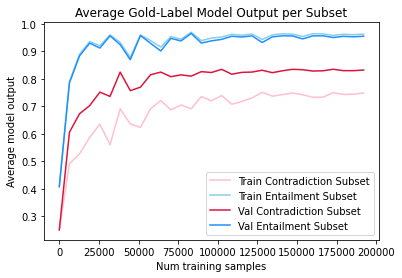

In [14]:
plt.plot(steps, train_cont_levels, label="Train Contradiction Subset", color="pink")
plt.plot(steps, train_ent_levels, label="Train Entailment Subset", color="skyblue")
plt.plot(steps, val_cont_levels, label="Val Contradiction Subset", color="crimson")
plt.plot(steps, val_ent_levels, label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num training samples")
plt.ylabel("Average model output")
plt.title("Average Gold-Label Model Output per Subset")
plt.legend()

In [15]:
train_dfs = [pd.DataFrame(array) for array in train_preds]
val_dfs = [pd.DataFrame(array) for array in val_preds]

In [16]:
for df in train_dfs:
    df.loc[train_conts, "label"] = "contradiction"
    df.loc[train_conts, "gold_pred"] = df[2]
    df.loc[train_ents, "label"] = "entailment"
    df.loc[train_ents, "gold_pred"] = df[0]
    df.drop([0, 1, 2], axis=1, inplace=True)
    df.dropna(inplace=True)
    
for df in val_dfs:
    df.loc[val_conts, "label"] = "contradiction"
    df.loc[val_conts, "gold_pred"] = df[2]
    df.loc[val_ents, "label"] = "entailment"
    df.loc[val_ents, "gold_pred"] = df[0]
    df.drop([0, 1, 2], axis=1, inplace=True)
    df.dropna(inplace=True)

In [17]:
percent = 0.1
negation_train_count = len(train_conts) + len(train_ents)
negation_val_count = len(val_conts) + len(val_ents)
negation_train_count, negation_val_count

(3683, 180)

In [18]:
train_worst = [df.sort_values("gold_pred", ascending=True).head(int(percent * negation_train_count)).groupby("label").count() for df in train_dfs]
val_worst = [df.sort_values("gold_pred", ascending=True).head(int(percent * negation_val_count)).groupby("label").count() for df in val_dfs]

/home/meissner/miniconda3/envs/lightning/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


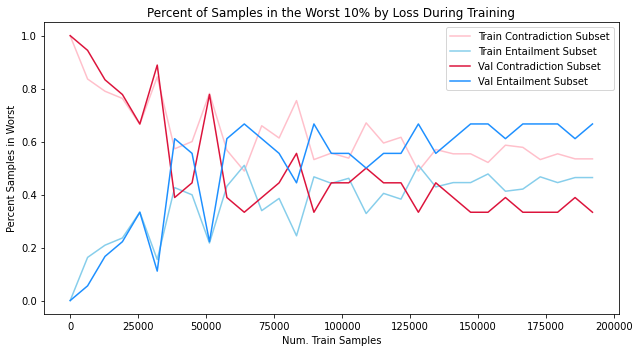

In [19]:
plt.rcParams["figure.figsize"] = (9,5)
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_train_count) if 'contradiction' in series.index else 0 for series in train_worst], label="Train Contradiction Subset", color="pink")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_train_count) if 'entailment' in series.index else 0 for series in train_worst], label="Train Entailment Subset", color="skyblue")
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_val_count) if 'contradiction' in series.index else 0 for series in val_worst], label="Val Contradiction Subset", color="crimson")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_val_count) if 'entailment' in series.index else 0 for series in val_worst], label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num. Train Samples")
plt.ylabel("Percent Samples in Worst")
plt.title("Percent of Samples in the Worst 10% by Loss During Training")
plt.legend()
plt.tight_layout()
plt.show()

## Check Training Dynamics (old)

In [25]:
base_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/"
train_preds = [np.load(_file) for _file in [base_path + "train_predictions/" f"{step}.npy" for step in range(0, 31, 1)]]
val_preds = [np.load(_file) for _file in [base_path + "val_predictions/" f"{step}.npy" for step in range(0, 31, 1)]]

In [26]:
len(train_preds), train_preds[0].shape

(31, (392702, 3))

In [27]:
len(val_preds), val_preds[0].shape

(31, (9815, 3))

In [28]:
train_preds[0][train_conts, 0].mean()

0.3911318

In [29]:
val_preds[0][val_conts, 0].mean()

0.3916983

In [30]:
train_cont_levels = [preds[train_conts, 2].mean() for preds in train_preds]
train_ent_levels = [preds[train_ents, 0].mean() for preds in train_preds]
val_cont_levels = [preds[val_conts, 2].mean() for preds in val_preds]
val_ent_levels = [preds[val_ents, 0].mean() for preds in val_preds]

In [31]:
steps = [i*32*200 for i in range(len(train_preds))]

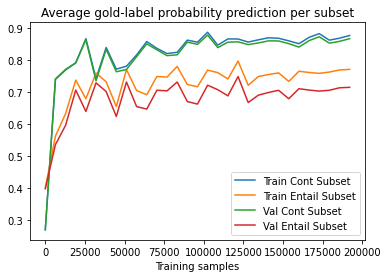

In [31]:
plt.plot(steps, train_cont_levels, label="Train Cont Subset")
plt.plot(steps, train_ent_levels, label="Train Entail Subset")
plt.plot(steps, val_cont_levels, label="Val Cont Subset")
plt.plot(steps, val_ent_levels, label="Val Entail Subset")
plt.xlabel("Training samples")
plt.title("Average gold-label probability prediction per subset")
plt.legend()

In [71]:
train_dfs = [pd.DataFrame(array) for array in train_preds]
# train_dfs = [df[train_conts]["label"] = "contradiction" for df in train_dfs]
# train_dfs = [df[train_ents]["label"] = "entailment" for df in train_dfs]

In [72]:
for df in train_dfs:
    df.loc[train_conts, "label"] = "contradiction"
    df.loc[train_conts, "gold_pred"] = df[2]
    df.loc[train_ents, "label"] = "entailment"
    df.loc[train_ents, "gold_pred"] = df[0]
    df.drop([0, 1, 2], axis=1, inplace=True)
    df.dropna(inplace=True)

In [ ]:
percent = 0.1
negation_train_count = len(train_conts) + len(train_ents)
negation_val_count = len(val_conts) + len(val_ents)
negation_train_count, negation_val_count

In [80]:
train_worst = [df.sort_values("gold_pred", ascending=True).head(int(0.3 * len(train_dfs))).groupby("label").count().unstack(fill_value=0).stack() for df in train_dfs]

AttributeError: 'Series' object has no attribute 'stack'

In [85]:
'contradiction' in train_worst[30].index

False

/home/meissner/miniconda3/envs/lightning/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


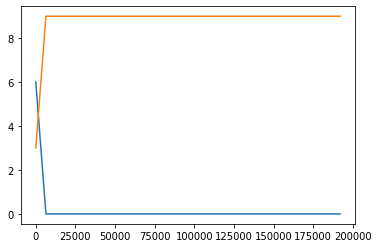

In [86]:
plt.rcParams["figure.figsize"] = (9,5)
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_train_count) if 'contradiction' in series.index else 0 for series in train_worst], label="Train Contradiction Subset", color="pink")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_train_count) if 'entailment' in series.index else 0 for series in train_worst], label="Train Entailment Subset", color="skyblue")
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_val_count) if 'contradiction' in series.index else 0 for series in val_worst], label="Val Contradiction Subset", color="crimson")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_val_count) if 'entailment' in series.index else 0 for series in val_worst], label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num. Train Samples")
plt.ylabel("Percent Samples in Worst")
plt.title("Percent of Samples in the Worst 10% by Loss During Training")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
train_pds = [pd.concat(df[train

,0,1,2
0,0.416687,0.337670,0.245643
1,0.413932,0.342713,0.243355
2,0.388892,0.341431,0.269677
3,0.384931,0.344804,0.270264
4,0.412009,0.333420,0.254571
...,...,...,...
392697,0.414637,0.337274,0.248089
392698,0.385311,0.341134,0.273554
392699,0.409094,0.347776,0.243131
392700,0.400275,0.339394,0.260330
